# Unsupervised Learning

In this notebook, we will explore unsupervised learning techniques to identify clusters of similar users based on their workout data. The goal is to recommend workout buddies for users based on their workout patterns, as users within the same cluster are assumed to have similar fitness activity profiles.

To accomplish this, we will perform clustering on the dataset and visualize the clusters to understand the relationships between users based on their workout activities.

## Table of Contents
1. [Data Preprocessing for Clustering](#)
1. [Determine the Optimal Number of Clusters](#)
1. [Cluster Analysis and Visualization](#)

**View this notebook in:**

<a href="https://colab.research.google.com/github/tky1026/nus_it5100f/blob/main/notebook/assignment3.ipynb" target="_blank">
    <img src="https://img.shields.io/badge/Open%20in-Colab-blue?logo=google-colab&style=for-the-badge" alt="Open in Colab"/>
</a>

<a href="https://github.com/tky1026/nus_it5100f" target="_blank">
    <img src="https://img.shields.io/badge/GitHub-Pages-blue?logo=github&style=for-the-badge" alt="GitHub Pages"/>
</a>

<a href="https://github.com/tky1026/nus_it5100f/blob/main/notebook/assignment3.ipynb" target="_blank">
    <img src="https://img.shields.io/badge/View-Notebook-orange?logo=jupyter&style=for-the-badge" alt="View Notebook"/>
</a>

---

**Note:**

> This notebook is a continuation of the previous data preprocessing and exploratory data analysis steps. Before proceeding, it's important to have completed the steps in **Data Preprocessing & EDA**, where we cleaned and transformed the Endomondo dataset. As a result of those steps, we saved the preprocessed data into a CSV file.
>
>The pre-requisite for this notebook is the CSV file (`endomondo_proper_cleaned_expanded.csv`), which was generated during the earlier part of the project. This file contains the cleaned dataset, which we will now use to apply various supervised learning techniques.

## Setup

Before diving into clustering, let's start with the setup. Here, we import the necessary libraries, mounting Google Drive to access the dataset, and loading the preprocessed data from the previous assignment.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the csv file
file_path_to_csv = "/content/drive/My Drive/IT5100F Project/data/endomondo_proper_cleaned_expanded.csv"

# Load the data into DataFrame
endomondo_df = pd.read_csv(file_path_to_csv)

# Display the first few rows of the DataFrame
endomondo_df.head()

Mounted at /content/drive


,altitude,heart_rate,id,latitude,longitude,speed,sport,timestamp
0,41.6,100,396826535.0,60.173349,24.649770,6.8652,bike,2014-08-24 16:45:46
1,40.6,111,396826535.0,60.173240,24.650143,16.4736,bike,2014-08-24 16:45:54
2,40.6,120,396826535.0,60.172980,24.650911,19.1988,bike,2014-08-24 16:46:05
3,38.4,119,396826535.0,60.172478,24.650669,20.4804,bike,2014-08-24 16:46:18
4,37.0,120,396826535.0,60.171861,24.649145,31.3956,bike,2014-08-24 16:46:34


## 1 Data Preprocessing for Clustering

### 1.1 Filter Data for Specific Sport - Bike
Let’s filter the dataset to include only users who have participated in `bike`.

In [3]:
# Filter the dataset for users who participate in the sport "bike"
bike_df = endomondo_df[endomondo_df['sport'] == 'bike'].copy()
bike_df.head()

,altitude,heart_rate,id,latitude,longitude,speed,sport,timestamp
0,41.6,100,396826535.0,60.173349,24.649770,6.8652,bike,2014-08-24 16:45:46
1,40.6,111,396826535.0,60.173240,24.650143,16.4736,bike,2014-08-24 16:45:54
2,40.6,120,396826535.0,60.172980,24.650911,19.1988,bike,2014-08-24 16:46:05
3,38.4,119,396826535.0,60.172478,24.650669,20.4804,bike,2014-08-24 16:46:18
4,37.0,120,396826535.0,60.171861,24.649145,31.3956,bike,2014-08-24 16:46:34


### 1.2 Generate Average Speed Dataset

In this step, we will create a new dataset that contains each user's id along with their average speed (`avg_speed`). This will allow us to identify users who have similar average biking speeds, which is useful for clustering and recommending workout buddies.

In [4]:
bike_avg_speed = bike_df.groupby('id')['speed'].mean().reset_index()
bike_avg_speed.rename(columns={'speed': 'avg_speed'}, inplace=True)
bike_avg_speed.head()

,id,avg_speed
0,9633831.0,29.879453
1,10544802.0,29.825676
2,11426022.0,25.096514
3,11639926.0,24.416834
4,11908018.0,30.805798


### 1.3 Compute Total Workout Time

This section calculates the total workout time for each user in the filtered biking dataset (assuming each user should only have clocked in one workout session in the dataset). By finding the difference between the maximum and minimum timestamps, we can determine the duration of each workout in seconds.

In [5]:
# Ensure the 'timestamp' column is in datetime format
bike_df['timestamp'] = pd.to_datetime(bike_df['timestamp'])

# Compute total workout time for each user based on the difference between max and min timestamps
bike_workout_time = bike_df.groupby('id')['timestamp'].agg(
    workout_time=lambda x: (x.max() - x.min()).total_seconds()
).reset_index()

# Display the resulting dataset
bike_workout_time.head()

,id,workout_time
0,9633831.0,4900.0
1,10544802.0,4608.0
2,11426022.0,7698.0
3,11639926.0,8880.0
4,11908018.0,11046.0


### 1.4 Compute Total Distance Covered

We calculate the total distance covered by each user during their biking activities. We estimate the distance traveled by considering the user's speed over individual time intervals, based on the assumption that each row represents a point where the user's speed changes and remains constant until the next recorded point.

-  For each row, the distance traveled is computed as the product of `time_elapsed` and speed, adjusted by `speed_diff` to account for changes from the previous row.

- Since the speed data is provided in kilometers per hour (km/h), we convert it to meters per second (m/s) by multiplying by (1000 / 3600).

- The distances between consecutive rows are aggregated for each user to obtain the total distance covered during their biking sessions.



> Note: The script includes checks to generate `speed_diff` and `time_elapsed` if they are not already present



In [6]:
# Check if 'speed_diff' column exists; if not, calculate it
if 'speed_diff' not in bike_df.columns:
    # Calculate the difference in speed between consecutive entries for each user
    bike_df['speed_diff'] = bike_df.groupby('id')['speed'].diff().fillna(0)
    print("Generated 'speed_diff' column.")

# Check if 'time_elapsed' column exists; if not, calculate it
if 'time_elapsed' not in bike_df.columns:
    # Ensure timestamp is in datetime format
    bike_df['timestamp'] = pd.to_datetime(bike_df['timestamp'])

    # Calculate time difference between consecutive entries in seconds
    bike_df['time_elapsed'] = bike_df.groupby('id')['timestamp'].diff().dt.total_seconds().fillna(0)
    print("Generated 'time_elapsed' column.")

Generated 'speed_diff' column.
Generated 'time_elapsed' column.


In [7]:
# Calculate distance travelled for each entry (meters)
bike_df.loc[:, 'distance_travelled'] = (
    bike_df['time_elapsed'] *
    ((bike_df['speed'] - bike_df['speed_diff']) * 1000 / 3600)  # Convert km/h to m/s
)

# Calculate the total distance covered by each user by summing up the distances
bike_distance = bike_df.groupby('id')['distance_travelled'].sum().reset_index()
bike_distance.head()

,id,distance_travelled
0,9633831.0,37274.625
1,10544802.0,38384.527
2,11426022.0,41596.060
3,11639926.0,45363.232
4,11908018.0,95269.566


### 1.5 Merge Processed Data

We’ll merge the three datasets by concatenating them along the columns, ensuring each user has their average speed, total workout time, and total distance included in the final DataFrame.

In [8]:
# Merge the datasets by concatenating along columns
user_merged_df = pd.concat(
    [bike_avg_speed, bike_workout_time[['workout_time']], bike_distance[['distance_travelled']]],
    axis=1
)

# Rename columns for clarity
user_merged_df.rename(columns={'distance_travelled': 'total_distance'}, inplace=True)
user_merged_df.head()


,id,avg_speed,workout_time,total_distance
0,9633831.0,29.879453,4900.0,37274.625
1,10544802.0,29.825676,4608.0,38384.527
2,11426022.0,25.096514,7698.0,41596.060
3,11639926.0,24.416834,8880.0,45363.232
4,11908018.0,30.805798,11046.0,95269.566


## 2 Determine the Optimal Number of Clusters

To find the optimal number of clusters for our dataset, we will use **K-Means clustering** on the `user_merged_df` and evaluate the inertia for different cluster numbers. Inertia measures the compactness of clusters, with lower values indicating more tightly packed clusters. By comparing inertia across a range of cluster counts, we can identify the optimal number of clusters for our data.

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

### 2.1 Run K-Means for Different Cluster Numbers

Before running K-Means, we normalize the data to ensure all features contribute equally to the distance calculations. This is important as K-Means is sensitive to feature scaling.


In [10]:
# Normalize the data
min_max_scaler = MinMaxScaler()
data = min_max_scaler.fit_transform(user_merged_df[['avg_speed', 'workout_time', 'total_distance']])

We utilised k-means++ for the initial selection of centroids instead of random selection because it provides the following benefits:
- **Better Initial Centroids / Reduced Sensitivity to Initialization:** K-means++ selects initial centroids in such a way that they are more spread out across the dataset, mitigating the problem of K-means being sensitive to initial conditions and reducing the likelihood of poor clustering results that can occur with random initialization.
- **Faster Convergence:** K-means++ often leads to faster convergence to a solution because the starting centroids are chosen in a way that makes the algorithm more efficient.
- **Improved Clustering Quality:** K-means++ often achieves lower within-cluster variance (or inertia), i.e., the points in each cluster are closer to their respective centroids as compared to random initialization.

In [11]:
# Initialize a list to store inertia values
inertia_data = []

# Run K-Means clustering for cluster counts from 2 to 11 and store inertia in the list
for c in range(2, 12):
    kmeans = KMeans(n_clusters=c, init="k-means++", random_state=42)
    inertia = kmeans.fit(data).inertia_
    # Append the cluster size and inertia to the list
    inertia_data.append({'cluster_size': c, 'inertia': round(inertia, 3)})

# Convert the list to a DataFrame
inertia_df = pd.DataFrame(inertia_data)

# Display inertia values for reference
print("Inertia values for different cluster sizes:")
print(inertia_df)

Inertia values for different cluster sizes:
   cluster_size  inertia
0             2  274.661
1             3  167.940
2             4  132.113
3             5  113.488
4             6   98.388
5             7   86.463
6             8   78.968
7             9   69.379
8            10   63.654
9            11   57.961


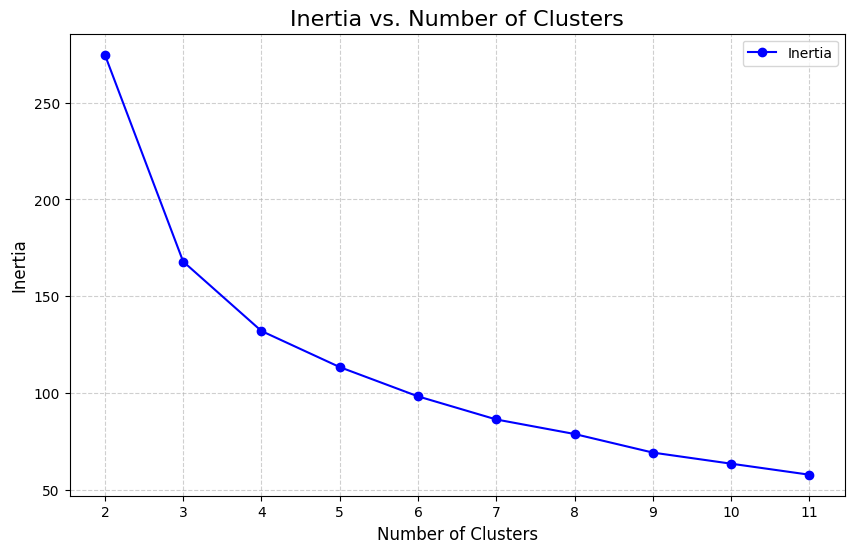

In [12]:
# Visualize inertia values to identify the optimal number of clusters (Elbow Method)
plt.figure(figsize=(10, 6))
plt.plot(inertia_df['cluster_size'], inertia_df['inertia'], marker='o', color='b', label='Inertia')
plt.title("Inertia vs. Number of Clusters", fontsize=16)
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Inertia", fontsize=12)
plt.xticks(np.arange(2, 12, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


### 2.2 Elbow Method for Optimal Clusters

We use the **Elbow Method** to identify the optimal number of clusters for our dataset. The Elbow Method involves plotting the inertia (sum of squared distances to the nearest cluster center) against the number of clusters. The goal is to find the point where inertia begins to decrease more slowly, which suggests that additional clusters provide diminishing returns in compactness.

To locate the elbow point programmatically, we employ the Distance to Line method:

- We calculate the perpendicular distance of each point on the inertia plot from a line connecting the first and last points.
- The point with the maximum distance from this line is considered the elbow, indicating the optimal cluster count.
- The largest distance corresponds to the point where inertia begins to decrease at a slower rate, making it an ideal choice for the number of clusters.


In [13]:
# This method programmatically locates the elbow point and finds the optimal value for the number of clusters for k-means clustering
def find_elbow(k_values, inertia_values):
      # Convert to numpy arrays for easier manipulation
      k_values = np.array(k_values)
      inertia_values = np.array(inertia_values)

      # Line connecting the first and last points
      p1 = np.array([k_values[0], inertia_values[0]])  # First point
      p2 = np.array([k_values[-1], inertia_values[-1]])  # Last point

      # Calculate the distances from each point to the line
      distances = []
      for i in range(len(k_values)):
          # Calculate the distance between each point and the line
          point = np.array([k_values[i], inertia_values[i]])
          distance = np.abs(np.cross(p2 - p1, point - p1) / np.linalg.norm(p2 - p1))
          distances.append(distance)

      # Find the index of the maximum distance, which corresponds to the elbow point
      elbow_index = np.argmax(distances)

      return k_values[elbow_index]

elbow_point = find_elbow(inertia_df['cluster_size'], inertia_df['inertia'])
print(f"The optimal number of clusters is: {elbow_point}")

The optimal number of clusters is: 4


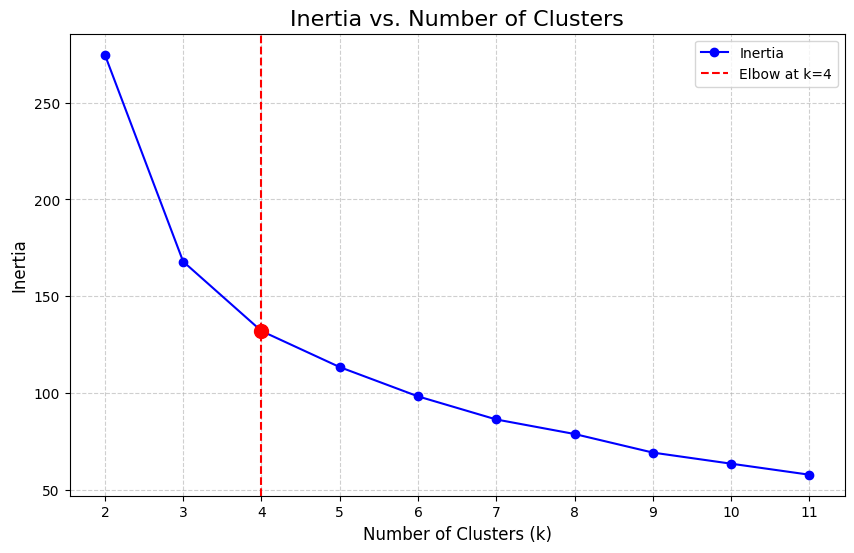

In [14]:
# Plot the inertia curve and the elbow point
plt.figure(figsize=(10, 6))
plt.plot(inertia_df['cluster_size'], inertia_df['inertia'], marker='o', color='b', label='Inertia')
plt.axvline(x=elbow_point, color='r', linestyle='--', linewidth=1.5, label=f'Elbow at k={elbow_point}')
plt.scatter(elbow_point, inertia_df.loc[inertia_df['cluster_size'] == elbow_point, 'inertia'], color='red', s=100, zorder=5) # Highlight elbow point

plt.title('Inertia vs. Number of Clusters', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(np.arange(2, 12, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


## 3 Cluster Analysis and Visualization

To analyze clusters, we start by building a K-means model with the optimal number of clusters identified from the Elbow Method. In this step, we create the K-means model and add a new column to `user_merged_df` that indicates the cluster assignment for each user.

### 3.1 Identify the Cluster Number for Each User

In this step, we assign each user to a cluster based on their workout data, using the optimal number of clusters identified previously. By applying K-means clustering to the features in `user_merged_df`, we aim to group users into clusters that reflect similarities in their workout habits.

In [15]:
# Create and fit the K-means model to the data
kmeans = KMeans(n_clusters=elbow_point, init="k-means++")

# Fit the model and predict clusters
user_merged_df['cluster'] = kmeans.fit_predict(data)
user_merged_df.head()

,id,avg_speed,workout_time,total_distance,cluster
0,9633831.0,29.879453,4900.0,37274.625,3
1,10544802.0,29.825676,4608.0,38384.527,3
2,11426022.0,25.096514,7698.0,41596.060,3
3,11639926.0,24.416834,8880.0,45363.232,0
4,11908018.0,30.805798,11046.0,95269.566,2


### 3.2 Visualize the Clusters

To visualize the clusters effectively, especially when working with higher-dimensional data, we can use **Principal Component Analysis (PCA)** or **t-distributed stochastic neighbor embedding (t-SNE)** to reduce the dimensionality of the data to two components. This will allow us to plot the clusters on a 2D scatter plot and gain insights into how users are grouped based on their workout metrics.

Thereafter, we also visualised the k-means clusters on a chart of average speed against workout time. We decided to drop the distance covered field given that it is less important as compared to average speed or workout time.

In [16]:
from sklearn.decomposition import PCA

# Reduce data to 2 dimensions for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data)

# Get the centroids for each cluster and transform them into PCA space
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

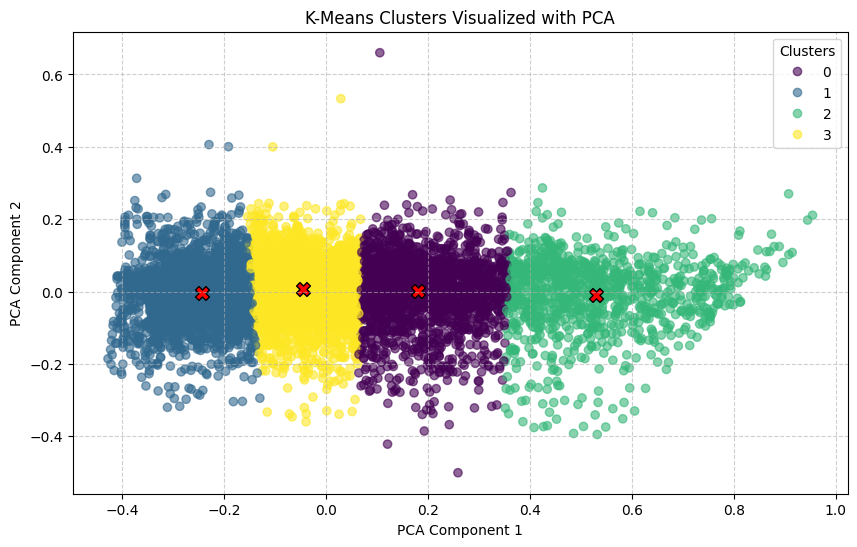

In [17]:
# Create a scatter plot of the PCA-reduced data, color-coded by cluster
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], c=user_merged_df['cluster'], cmap='viridis', alpha=0.6)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], color='red', marker='X', s=100, edgecolor='black')

# Add labels and legend for clusters
plt.title('K-Means Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [18]:
from sklearn.manifold import TSNE

# t-SNE does not support a transform() method, therefore it is not possible to separately transform the k-means clustering centroids to the same reduced space as the actual features clustered
# Therefore, the k-means cluster centroids are added to the original datapoints for dimensionality reduction with t-SNE
# Thereafter, the reduced k-means cluster centroids will be separated from the reduced datapoints and plotted separately

data_with_centroids = pd.DataFrame(np.vstack((data, kmeans.cluster_centers_)))

# Reduce the dimensions to 2 using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(data_with_centroids)

# Separate the reduced datapoints from the reduced centroids
tsne_data = tsne_components[:-kmeans.n_clusters]
centroids_tsne = tsne_components[-kmeans.n_clusters:]

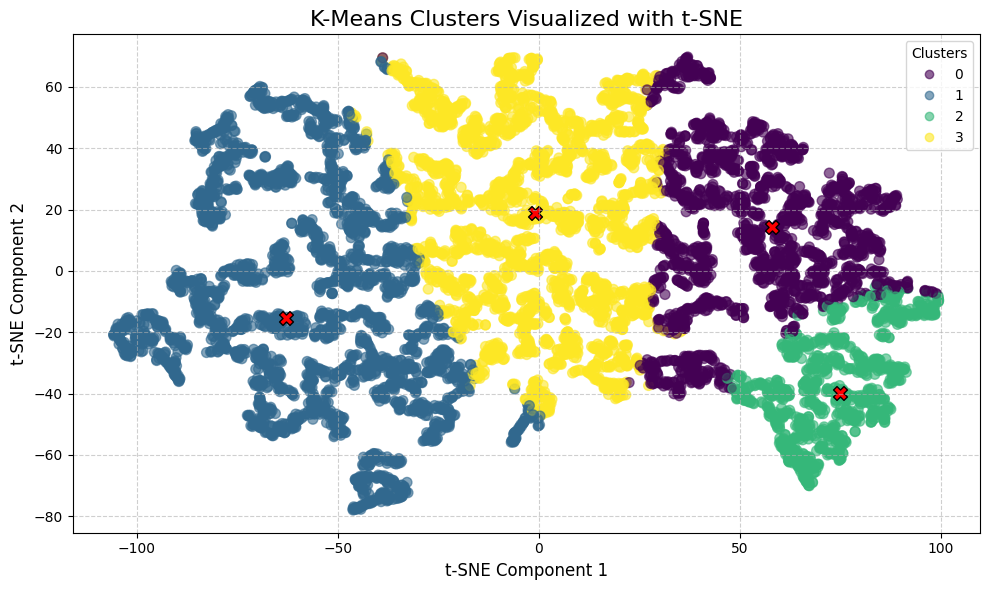

In [19]:
# Create a scatter plot of the t-SNE-reduced data, color-coded by cluster
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    tsne_data[:, 0],
    tsne_data[:, 1],
    c=user_merged_df['cluster'],
    cmap='viridis',
    alpha=0.6,
    s=50
)

# Plot t-SNE-reduced k-means cluster centroids
plt.scatter(
    centroids_tsne[:, 0],
    centroids_tsne[:, 1],
    color='red',
    marker='X',
    s=100,
    edgecolor='black'
)

# Add labels and legend
plt.title('K-Means Clusters Visualized with t-SNE', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(*scatter.legend_elements(), title='Clusters', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

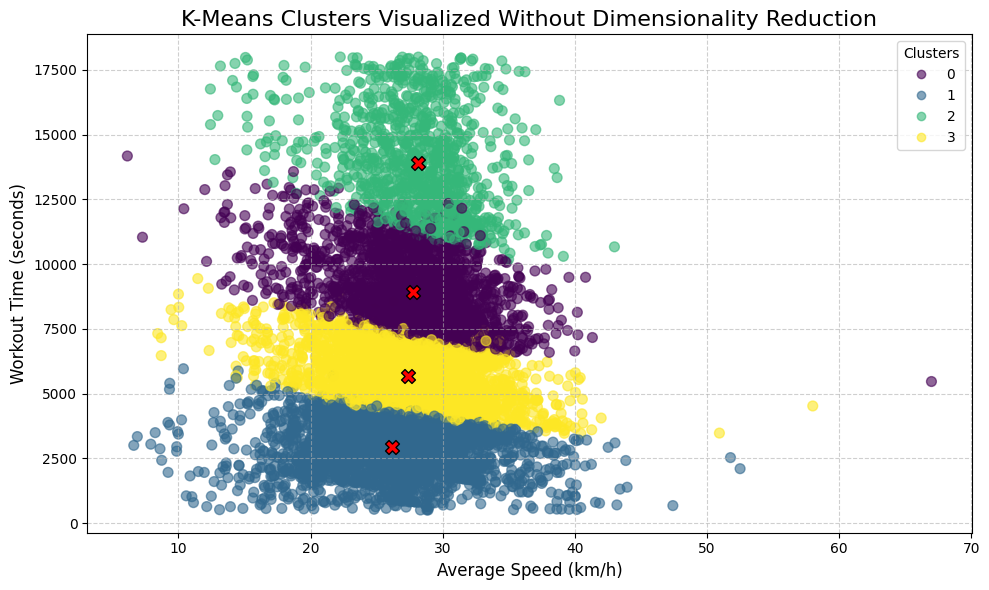

In [20]:
# Create a scatter plot of the data with no dimensionality reduction, color-coded by cluster
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    user_merged_df['avg_speed'],
    user_merged_df['workout_time'],
    c=user_merged_df['cluster'],
    cmap='viridis',
    alpha=0.6,
    s=50
)

# Calculate the centroids in the original scale and plot them (reverse the normalization)
centroids = min_max_scaler.inverse_transform(kmeans.cluster_centers_)

# Plot centroids with a distinct marker and color, but omit from the legend
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    color='red',
    marker='X',
    s=100,
    edgecolor='black'  # For a distinct look of centroids
)

# Add plot title and axis labels
plt.title('K-Means Clusters Visualized Without Dimensionality Reduction', fontsize=16)
plt.xlabel('Average Speed (km/h)', fontsize=12)
plt.ylabel('Workout Time (seconds)', fontsize=12)

# Customize the legend for clusters only (excluding centroids)
plt.legend(*scatter.legend_elements(), title='Clusters', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### 3.3 Identify Similar Users

In this step, we aim to find users with similar workout patterns, who can be recommended as potential workout buddies. This is done by leveraging the clusters we identified through K-means clustering.

Using this user with ID `377398220` as example, we begin by identifying which cluster the target user belongs to. Once the user’s cluster is identified, we filter our data to find all other users who belong to the same cluster. These users share similar workout habits and could make suitable workout buddies.


In [21]:
# Find the cluster label for the user with ID 377398220
user_id = 377398220
user_cluster = user_merged_df[user_merged_df['id'] == user_id]['cluster'].values[0]

# Identify other users in the same cluster
similar_users = user_merged_df[user_merged_df['cluster'] == user_cluster]

# Exclude the original user from the similar users list (optional)
similar_users = similar_users[similar_users['id'] != user_id]

# Display the similar users
print(f"User ID: {user_id} belongs to cluster {user_cluster}.")
print("Similar users in the same cluster (potential workout buddies):")
print(similar_users[['id', 'avg_speed', 'workout_time', 'total_distance', 'cluster']])

User ID: 377398220 belongs to cluster 1.
Similar users in the same cluster (potential workout buddies):
               id  avg_speed  workout_time  total_distance  cluster
8      13821125.0  30.283985        2850.0       24379.941        1
11     13841976.0  32.439161        2151.0       19210.465        1
12     13841978.0  32.531407        2149.0       19493.290        1
16     14150160.0  28.715638        2599.0       20590.476        1
17     14150166.0  29.672863        2381.0       19740.850        1
...           ...        ...           ...             ...      ...
9138  659391232.0  19.364573        4344.0       21169.166        1
9139  659391259.0  24.052054        3502.0       20467.415        1
9146  659391583.0  25.343453        3436.0       21611.522        1
9148  659392035.0  24.257599        2583.0       18065.359        1
9152  659392443.0  24.156734        3191.0       19569.183        1

[3216 rows x 5 columns]
